# 1. Import

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# 2. Data

### 2.1 Load Data

In [2]:
# import risk free rate
ff = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0) 
rf = ff.loc[:, "RF"] / 100
rf.index = pd.to_datetime(rf.index, format = "%Y%m")
rf = rf.loc[rf.index >= "1974-01-01"]  # only needed to calculate out-of-sample Sharpe ratios, hence only select data past 1974

# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
mask = (df <= -0.99)
df[mask] = np.nan

# nb of industries dataframe
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")
mask = (nb_industries <= -0.99)
nb_industries[mask] = np.nan

# average sizes dataframe
avg_size = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")
mask = (avg_size <= -0.99)
avg_size[mask] = np.nan

# sum of BE / sum of ME dataframe
be_over_me = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 4959, nrows = 99, header=0)
be_over_me.index = pd.to_datetime(be_over_me.index, format = "%Y")

In [3]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# momentum with monthly data
momentum = df.rolling(12).mean()

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").ffill()

# need to add missing portion of 2024 since data with shifted index is missing it
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)
mask = (be_over_me <= -99.99)
be_over_me[mask] = np.nan

### 2.2 Normalize Data

In [4]:
mkt_cap_ = mkt_cap.loc['1927-06-01':'1973-12-01']
mkt_cap_norm = mkt_cap_.sub(mkt_cap_.mean(axis = 1), axis = 0).div(mkt_cap_.std(axis = 1), axis = 0)
print(mkt_cap_norm.shape)

be_over_me_ = be_over_me.loc['1927-06-01':'1973-12-01']
be_over_me_norm = be_over_me_.sub(be_over_me_.mean(axis = 1), axis = 0).div(be_over_me_.std(axis = 1), axis = 0)
print(be_over_me_norm.shape)

momentum_ = momentum.loc['1927-06-01':'1973-12-01']
momentum_norm = momentum_.sub(momentum_.mean(axis = 1), axis = 0).div(momentum_.std(axis = 1), axis = 0)
print(momentum_norm.shape)

df_in = df.loc['1927-06-01':'1973-12-01']
print(df_in.shape)

(559, 48)
(559, 48)
(559, 48)
(559, 48)


# 3. Parameter Optimization

### 3.1 Objective Function

In [5]:
def CRRA(wealth: float, gamma = 5):
    """"
    Constant Relative Risk Aversion Utility Function
    ---
    :param wealth: current wealth level of investor
    :param gamma: risk aversion parameter
    :return: CRRA utility level as given by functional form in Brandt et al. (2009), equation 15
    """

    if gamma == 1:
        return np.log(wealth)
    else:
        return ((1 + wealth) ** (1 - gamma)) / (1 - gamma)

In [6]:
def objective(theta: np.ndarray, x: np.ndarray, rets: pd.DataFrame, mkt_cap: np.ndarray):
    """
    objective function (equation 6 from Brandt et al. (2009)) which we aim to optimize over each period.
    ---
    :param theta: parameter vector to be optimized
    :param x: characteristics matrix with dimensions (time x assets x characteristics)
    :param rets: universe of assets returns matrix
    :param mkt_cap: market capitalization of each asset in universe
    :return: negative CRRA utility over desired period (we wish to minimize the negative utility)
    """

    # initial wealth
    accrued_utility = 0.0
    for t in range(x.shape[0]):
        w_t = mkt_cap.iloc[t]/ mkt_cap.iloc[t].sum()  # current weights of market portfolio (our benchmark)
        rets_t1 = rets.iloc[t+1, :].values  # returns at time t+1 (following period)
        x_t = x[t, :, :]  # characteristics at time t
        
        # determine which assets are currently traded
        valid_mask = ~np.isnan(rets_t1) & ~np.isnan(x_t).any(axis=1)
        Nt = valid_mask.sum()
        
        if Nt > 0:
            # equation 6 from Brandt et al. (2009)
            accrued_utility += CRRA(np.sum((w_t[valid_mask] + (x_t[valid_mask] @ theta) / Nt) * rets_t1[valid_mask]))
    
    # we wish to minimize the negative value of equation 6 from Brandt et al. (2009)
    return - accrued_utility / x.shape[0]

In [7]:
characteristics = np.stack([mkt_cap_norm, be_over_me_norm, momentum_norm], axis= -1)  # 3 characteristics we're interested in
theta = np.array([-1.451, 3.606, 1.772])  # initial guess for theta

In [8]:
init = theta
response = minimize(objective, x0=init, args=(characteristics, df, mkt_cap), method= 'SLSQP')
response

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.15004521513458138
       x: [ 1.921e+00 -6.453e+00  1.531e+01]
     nit: 20
     jac: [ 1.866e-05  1.223e-05  3.781e-06]
    nfev: 81
    njev: 20

### 3.2 Parametric Weights at the end of In-Sample Period

In [9]:
# weights for the final period
weights = mkt_cap.loc['1973-12-01']/ mkt_cap.loc['1973-12-01'].sum()  # current weights of market portfolio (our benchmark)
next_w = np.zeros(weights.shape)
for i in range(len(weights)):
    next_w[i] = weights[i] + (response.x @ characteristics[-1,i,:]) / (np.count_nonzero(~np.isnan(characteristics[-1,:,:]))/3)

next_w

array([ 0.17076611,  0.07557561,  0.26801594,  0.17184921,  0.16550954,
       -0.41995883, -0.50305398, -0.20496803,  0.34910431, -0.6621435 ,
       -0.9322006 ,  0.22435635,  0.42879594,  0.35338853, -0.22879337,
       -0.51951205, -0.02362338,  0.0374836 ,  0.06310853,  0.27681506,
        0.21115421,  0.05742963, -0.23051798, -0.56123626,  0.59639736,
       -0.29723798,  0.90032186,  0.57022065,  0.37654913,  0.68631933,
        0.10833412,  0.20657885, -0.45456581, -0.09037793,  0.33069769,
       -0.00877334,  0.21087034,  0.4767633 ,  0.2436828 , -0.35899106,
       -0.16453919, -0.00981153, -0.21848914,  0.2138615 , -0.00310906,
       -0.6985023 , -0.00801239, -0.17553181])

In [10]:
# apply equation 16
def long_only_constraint(weights: np.array):
    """
    Imposes long only constraint through equation 16 of Brand et al. (2009) on the obtained weights using the optimized parameters
    ---
    :param weights: optimal weights to be constrained
    :return: optimal weights after applying long only constraint
    """

    # after completing optimization, we can safely set NaNs to 0 without affecting the optimized weights
    clean_weights = np.nan_to_num(weights, nan= 0)
    w_pos = np.clip(clean_weights, 0, None) # set all negative to 0
    return w_pos / np.sum(w_pos)


l_w = long_only_constraint(next_w)
l_w

array([0.02196646, 0.00972165, 0.03447616, 0.02210578, 0.02129028,
       0.        , 0.        , 0.        , 0.04490694, 0.        ,
       0.        , 0.02886002, 0.05515806, 0.04545804, 0.        ,
       0.        , 0.        , 0.00482169, 0.00811795, 0.03560803,
       0.02716177, 0.00738745, 0.        , 0.        , 0.07671742,
       0.        , 0.11581267, 0.07335019, 0.0484373 , 0.08828451,
       0.01393553, 0.02657322, 0.        , 0.        , 0.04253921,
       0.        , 0.02712525, 0.06132832, 0.03134607, 0.        ,
       0.        , 0.        , 0.        , 0.02751002, 0.        ,
       0.        , 0.        , 0.        ])

# 4. Out-of-Sample Testing

### 4.1 Load Out-of-Sample Data

In [11]:
# market cap characteristic out-of-sample
mkt_cap_ = mkt_cap.loc['1963-12-01':'2025-01-01']
mkt_cap_norm = mkt_cap_.sub(mkt_cap_.mean(axis = 1), axis = 0).div(mkt_cap_.std(axis = 1), axis = 0)
print(mkt_cap_norm.shape)

# book to equity characteristic out-of-sample
be_over_me_ = be_over_me.loc['1963-12-01':'2025-01-01']
be_over_me_norm = be_over_me_.sub(be_over_me_.mean(axis = 1), axis = 0).div(be_over_me_.std(axis = 1), axis = 0)
print(be_over_me_norm.shape)

# momentum characteristic out-of-sample
momentum_ = momentum.loc['1963-12-01':'2025-01-01']
momentum_norm = momentum_.sub(momentum_.mean(axis = 1), axis = 0).div(momentum_.std(axis = 1), axis = 0)
print(momentum_norm.shape)

# returns out-of-sample
df_out = df.loc['1963-12-01':'2025-01-01']
print(df_out.shape)


(733, 48)
(733, 48)
(733, 48)
(733, 48)


In [12]:
x_hat = np.stack([mkt_cap_norm, be_over_me_norm, momentum_norm], axis= -1)
window_size = 119 # 10 years x 12 months - 1 (current observation) = 119 timesteps
next_w = np.zeros(len(mkt_cap.columns))
monthly_rets = []
df_theta = pd.DataFrame(columns=['THETA1', 'THETA2', 'THETA3'])

### 4.2 Rolling Window

In [14]:
for t in tqdm(range(window_size+1, x_hat.shape[0]-1)): 
    x_hat_subset = x_hat[t-window_size-1:t-1, :, :]  # characteristics for estimation period over [0,t-1]
    df_out_subset = df_out.iloc[t-window_size-1:t]  # returns for estimation period which is shifted by one period since we use previous period's characteristic's, so it is over [1, t]
    mkt_cap_subset = mkt_cap_.iloc[t-window_size-1:t-1, :]  # market capitalization for estimation period (to calculate market weights at each period) over [0,t-1] 
    rets_t1 = df_out.iloc[t+1]  # returns for next period at t+1

    # 1. Estimate Theta
    res = minimize(objective, x0=theta, args=(x_hat_subset, df_out_subset, mkt_cap_subset), method='SLSQP')
    theta = res.x
    df_theta.loc[len(df_theta)] = res.x
    
    # 2. Estimate Weights
    Nt = np.count_nonzero(~np.isnan(x_hat_subset[-1, :, :])) / 3  # number of assets which have non NA values for each characteristic.
    valid_mask = ~np.isnan(x_hat_subset[-1, :, :]).any(axis=1)  # mask for assets which have non NA values for each characteristic.
    
    # parametric portfolio weights
    w_bar = mkt_cap_subset.iloc[-1]/ mkt_cap_subset.iloc[-1].sum()
    next_w[valid_mask] = w_bar[valid_mask] + (x_hat_subset[-1, valid_mask, :] @ theta) / Nt

    long_weights = long_only_constraint(next_w)

    # 3. Estimate Next Month Returns
    rets_clean = np.nan_to_num(rets_t1, nan=0)
    
    # 4. Record Return
    monthly_rets.append(long_weights @ rets_clean)

monthly_rets = pd.Series(monthly_rets, index = df_out.index[window_size+2:], dtype="float64")

100%|██████████| 612/612 [02:15<00:00,  4.53it/s]


Text(0, 0.5, 'Values')

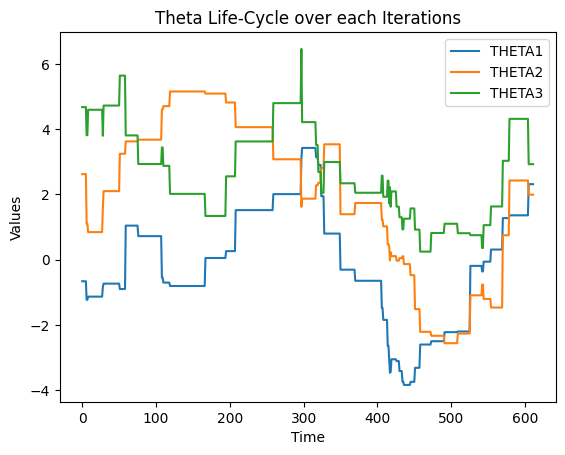

In [18]:
df_theta.plot()
plt.title("Theta Life-Cycle over each Iterations")
plt.xlabel("Time")
plt.ylabel("Values")

In [ ]:
print(f'mean: {12 * np.mean(monthly_rets)}')
print(f'std: {np.sqrt(12) * np.std(monthly_rets, ddof = 1)}')
print(f'sharpe: {np.sqrt(12) * np.mean(monthly_rets - rf)/np.std(monthly_rets, ddof = 1)}')

mean: 0.15168451651212245
std: 0.17192295004270824
sharpe: 0.6334928958900439


# 5. Comparison with Equal Weight and Inverse Variance

In [ ]:
def inv_var(df: pd.DataFrame):
    """
    computes weights based on the inverse of the variance of assets
    ---
    :param df: dataframe of industry returns
    :return: array of inverse variance weights
    """
    
    w = (1 / df.var(axis = 0)) / sum(1 / df.var(axis = 0))
    return w


def equal_weight(df: pd.DataFrame):
    """
    computes equal weights for each asset in the portfolio (1 / N portfolio)
    ---
    :param df: dataframe of industry returns
    :return: array of equal weights
    """
    
    return np.full(len(df.columns), fill_value = 1 / len(df.columns))

In [ ]:
backtest = pd.DataFrame(index = df_out[window_size+1:].index, columns = ["parametric", "inv_var", "equal_weight"], dtype = "float")

for t in tqdm(range(window_size+1, df_out.shape[0]-1)):
    
    # construct portfolio based off of 5 years of data
    start = df_out.index[t - window_size]
    end = df_out.index[t]

    # current date (is 1 month ahead to avoid look-ahead bias)
    current = df_out.index[t+1]

    backtest.loc[current, "inv_var"] = df_out.loc[current, :] @ inv_var(df_out.loc[start:end,:])
    backtest.loc[current, "equal_weight"] = df_out.loc[current, :] @ equal_weight(df_out.loc[start:end,:])

100%|██████████| 612/612 [00:00<00:00, 773.80it/s]


Text(0, 0.5, 'Cumulative Returns (Log Scale)')

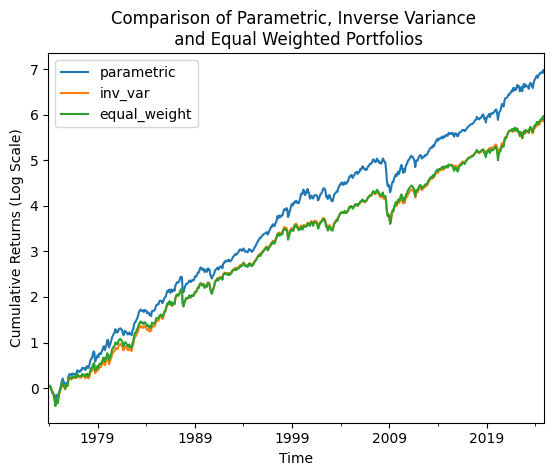

In [ ]:
backtest.loc[:, "parametric"] = monthly_rets
np.log(np.cumprod(1 + backtest)).plot()
plt.title("Comparison of Parametric, Inverse Variance \n and Equal Weighted Portfolios")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (Log Scale)")

In [ ]:
mean_rets = backtest.mean(axis = 0) * 12
std_rets = backtest.std(axis = 0) * np.sqrt(12)
sharpe_ratios = backtest.sub(rf, axis = 0).mean(axis = 0) * np.sqrt(12) / backtest.std(axis = 0)

pd.DataFrame({"mean": mean_rets, "std": std_rets, "sharpe": sharpe_ratios})

,mean,std,sharpe
parametric,0.151685,0.171923,0.633493
inv_var,0.127740,0.157331,0.540056
equal_weight,0.130728,0.169281,0.519585
